In [341]:
import numpy as np
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import seaborn as sns
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC, DiagGGNExact

plt.rcParams["figure.figsize"] = (20,10)
torch.set_default_dtype(torch.float64)

In [334]:
def NN(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(13, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        #extension starts here
        torch.nn.Linear(sz, 1)
        
    )
    return(features)

def NN_deep(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(13, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        #extension starts here
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, 1)
        
    )
    return(features)

net = NN(sz= 14)

lossfunction = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

/Users/moreez/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Boston Housing datawrangling

In [405]:
net.train()

Sequential(
  (0): Linear(in_features=13, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=14, bias=True)
  (2): Linear(in_features=14, out_features=14, bias=True)
  (3): Linear(in_features=14, out_features=14, bias=True)
  (4): Linear(in_features=14, out_features=14, bias=True)
  (5): Linear(in_features=14, out_features=1, bias=True)
)

In [406]:
class BostonDataset(data.Dataset):
    def __init__(self, train=True):
        super(BostonDataset, self).__init__()
            
        boston = load_boston()
        
        X,y   = boston.data, boston.target
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        #if train:
        self.inputs, self.labels = X, y

        #else:
        #    self.inputs, self.labels = X_test, y_test
    
    def __getitem__(self, index):
        inp = torch.Tensor(self.inputs[index])
        label = torch.LongTensor([self.labels[index]])
        return inp, label
    def __len__(self):
        return len(self.inputs)

In [397]:
bostondataloader = data.DataLoader(BostonDataset(train=True), batch_size=32, shuffle=True, num_workers=0)

In [333]:
for i, (x, y) in enumerate(bostondataloader):
    if i >0:
        break
    print(y.size())
    print(x.size())
    print(y)

torch.Size([32, 1])
torch.Size([32, 13])
tensor([[17],
        [28],
        [22],
        [19],
        [31],
        [19],
        [41],
        [34],
        [16],
        [25],
        [23],
        [22],
        [18],
        [48],
        [30],
        [25],
        [11],
        [17],
        [14],
        [21],
        [17],
        [26],
        [20],
        [19],
        [43],
        [24],
        [22],
        [18],
        [23],
        [14],
        [23],
        [34]])


In [278]:
dataset = TensorDataset(torch.from_numpy(boston.data).clone(), torch.from_numpy(boston.target).reshape(506,1).clone())
loader = DataLoader(dataset=dataset, batch_size=506, shuffle=True)

## train the model

In [290]:
def metric(inferred_tensor: torch.Tensor, ground_truth: torch.Tensor) -> torch.Tensor:
        """Classification Accuracy
        example)
        inferred_tensor: [[0,0,1], [0,1,0]]
        ground_truth: [2, 0]
        return: 0.5
        :param inferred_tensor: (torch.Tensor) [batch_size, n_classes(3)], inferred logits
        :param ground_truth:  (torch.LongTensor) [batch_size], ground truth labels
                                each consisting LongTensor ranging from 0 to 2
        :return: (torch.Tensor) metric
        """

        inferred_tensor = torch.argmax(inferred_tensor, dim=-1)
        acc = torch.mean((inferred_tensor == ground_truth).to(torch.float), dim=-1)
        return acc

In [407]:
#torch.set_default_dtype(torch.double)
def train(model, criterion, optim, num_epochs, device = 'cpu'):
    running_loss = 0.0
    for epoch in range(num_epochs):
        for x, y in bostondataloader:
            #x, y = x.float(), y.float()
            inputs = x
            targets = y            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            loss.double()
            loss.backward()
            optimizer.step()
            
            running_loss =+ loss.item()
            
        print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
    #running_loss = 0.0

In [408]:
train(net, lossfunction, optimizer, 100)

RuntimeError: expected dtype Double but got dtype Long (validate_dtype at /Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/aten/src/ATen/native/TensorIterator.cpp:143)
frame #0: c10::Error::Error(c10::SourceLocation, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 135 (0x1a2773eab7 in libc10.dylib)
frame #1: at::TensorIterator::compute_types() + 4335 (0x1a212e82ef in libtorch_cpu.dylib)
frame #2: at::TensorIterator::build() + 690 (0x1a212ec692 in libtorch_cpu.dylib)
frame #3: at::native::mse_loss_backward_out(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 520 (0x1a211243d8 in libtorch_cpu.dylib)
frame #4: at::CPUType::mse_loss_backward_out_grad_input(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 247 (0x1a2159bd17 in libtorch_cpu.dylib)
frame #5: at::native::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 193 (0x1a211240d1 in libtorch_cpu.dylib)
frame #6: at::CPUType::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 234 (0x1a2159c06a in libtorch_cpu.dylib)
frame #7: c10::detail::wrap_kernel_functor_unboxed_<c10::detail::WrapRuntimeKernelFunctor_<at::Tensor (*)(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long), at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, at::Tensor const&, long long> >, at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, long long)>::call(c10::OperatorKernel*, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 27 (0x1a215d658b in libtorch_cpu.dylib)
frame #8: torch::autograd::VariableType::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 2608 (0x1a233a8aa0 in libtorch_cpu.dylib)
frame #9: c10::detail::wrap_kernel_functor_unboxed_<c10::detail::WrapRuntimeKernelFunctor_<at::Tensor (*)(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long), at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, at::Tensor const&, long long> >, at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, long long)>::call(c10::OperatorKernel*, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 27 (0x1a215d658b in libtorch_cpu.dylib)
frame #10: at::Tensor c10::OperatorHandle::callUnboxed<at::Tensor, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long>(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) const + 294 (0x1a224d2276 in libtorch_cpu.dylib)
frame #11: torch::autograd::generated::MseLossBackward::apply(std::__1::vector<at::Tensor, std::__1::allocator<at::Tensor> >&&) + 311 (0x1a230fca07 in libtorch_cpu.dylib)
frame #12: torch::autograd::Node::operator()(std::__1::vector<at::Tensor, std::__1::allocator<at::Tensor> >&&) + 658 (0x1a238c4ed2 in libtorch_cpu.dylib)
frame #13: torch::autograd::Engine::evaluate_function(std::__1::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 1408 (0x1a238bb6a0 in libtorch_cpu.dylib)
frame #14: torch::autograd::Engine::thread_main(std::__1::shared_ptr<torch::autograd::GraphTask> const&, bool) + 497 (0x1a238ba8b1 in libtorch_cpu.dylib)
frame #15: torch::autograd::Engine::thread_init(int) + 152 (0x1a238ba648 in libtorch_cpu.dylib)
frame #16: torch::autograd::python::PythonEngine::thread_init(int) + 52 (0x1a20406a04 in libtorch_python.dylib)
frame #17: void* std::__1::__thread_proxy<std::__1::tuple<std::__1::unique_ptr<std::__1::__thread_struct, std::__1::default_delete<std::__1::__thread_struct> >, void (torch::autograd::Engine::*)(int), torch::autograd::Engine*, int> >(void*) + 66 (0x1a238c9c32 in libtorch_cpu.dylib)
frame #18: _pthread_start + 148 (0x7fff71caa109 in libsystem_pthread.dylib)
frame #19: thread_start + 15 (0x7fff71ca5b8b in libsystem_pthread.dylib)


In [327]:
train_boston(net, lossfunction, optimizer, num_epochs=1500)

[1/1500] >Loss: 111.08, Acc: 5.31%
[2/1500] >Loss: 90.23, Acc: 2.50%
[3/1500] >Loss: 82.43, Acc: 1.88%
[4/1500] >Loss: 79.28, Acc: 2.50%
[5/1500] >Loss: 75.60, Acc: 1.88%
[6/1500] >Loss: 80.19, Acc: 1.56%
[7/1500] >Loss: 67.23, Acc: 3.75%
[8/1500] >Loss: 68.42, Acc: 5.00%
[9/1500] >Loss: 66.57, Acc: 2.19%
[10/1500] >Loss: 64.36, Acc: 4.69%
[11/1500] >Loss: 57.22, Acc: 2.19%
[12/1500] >Loss: 51.84, Acc: 1.56%
[13/1500] >Loss: 53.23, Acc: 2.81%
[14/1500] >Loss: 66.09, Acc: 5.94%
[15/1500] >Loss: 55.36, Acc: 3.44%
[16/1500] >Loss: 52.22, Acc: 4.69%
[17/1500] >Loss: 60.46, Acc: 5.31%
[18/1500] >Loss: 94.25, Acc: 2.81%
[19/1500] >Loss: 79.46, Acc: 5.31%
[20/1500] >Loss: 58.83, Acc: 3.44%
[21/1500] >Loss: 65.04, Acc: 5.31%
[22/1500] >Loss: 54.06, Acc: 4.69%
[23/1500] >Loss: 49.89, Acc: 3.44%
[24/1500] >Loss: 46.19, Acc: 4.06%
[25/1500] >Loss: 54.10, Acc: 5.62%
[26/1500] >Loss: 45.40, Acc: 3.12%
[27/1500] >Loss: 50.74, Acc: 3.62%
[28/1500] >Loss: 50.95, Acc: 2.50%
[29/1500] >Loss: 54.41, Acc:

[233/1500] >Loss: 34.54, Acc: 3.44%
[234/1500] >Loss: 33.10, Acc: 1.88%
[235/1500] >Loss: 35.55, Acc: 2.19%
[236/1500] >Loss: 37.29, Acc: 5.00%
[237/1500] >Loss: 38.63, Acc: 4.69%
[238/1500] >Loss: 35.86, Acc: 4.06%
[239/1500] >Loss: 39.08, Acc: 3.12%
[240/1500] >Loss: 33.55, Acc: 2.50%
[241/1500] >Loss: 34.58, Acc: 5.31%
[242/1500] >Loss: 38.31, Acc: 2.19%
[243/1500] >Loss: 37.11, Acc: 4.06%
[244/1500] >Loss: 39.75, Acc: 3.12%
[245/1500] >Loss: 39.08, Acc: 3.44%
[246/1500] >Loss: 41.18, Acc: 4.06%
[247/1500] >Loss: 38.37, Acc: 3.44%
[248/1500] >Loss: 32.59, Acc: 3.12%
[249/1500] >Loss: 33.68, Acc: 3.44%
[250/1500] >Loss: 36.60, Acc: 2.50%
[251/1500] >Loss: 37.23, Acc: 5.00%
[252/1500] >Loss: 35.37, Acc: 1.25%
[253/1500] >Loss: 36.72, Acc: 3.12%
[254/1500] >Loss: 41.99, Acc: 4.38%
[255/1500] >Loss: 33.38, Acc: 4.06%
[256/1500] >Loss: 36.60, Acc: 6.25%
[257/1500] >Loss: 32.94, Acc: 5.62%
[258/1500] >Loss: 42.94, Acc: 3.12%
[259/1500] >Loss: 34.77, Acc: 3.75%
[260/1500] >Loss: 33.36, Acc

[465/1500] >Loss: 37.17, Acc: 5.00%
[466/1500] >Loss: 32.76, Acc: 7.19%
[467/1500] >Loss: 36.69, Acc: 4.06%
[468/1500] >Loss: 34.99, Acc: 4.06%
[469/1500] >Loss: 31.64, Acc: 3.12%
[470/1500] >Loss: 33.28, Acc: 6.56%
[471/1500] >Loss: 33.85, Acc: 3.44%
[472/1500] >Loss: 34.74, Acc: 6.88%
[473/1500] >Loss: 36.68, Acc: 3.44%
[474/1500] >Loss: 37.55, Acc: 3.75%
[475/1500] >Loss: 36.24, Acc: 5.31%
[476/1500] >Loss: 36.91, Acc: 2.81%
[477/1500] >Loss: 34.39, Acc: 5.00%
[478/1500] >Loss: 35.17, Acc: 4.69%
[479/1500] >Loss: 38.84, Acc: 3.12%
[480/1500] >Loss: 35.52, Acc: 3.44%
[481/1500] >Loss: 37.60, Acc: 4.69%
[482/1500] >Loss: 37.34, Acc: 5.00%
[483/1500] >Loss: 35.79, Acc: 2.81%
[484/1500] >Loss: 36.30, Acc: 3.75%
[485/1500] >Loss: 37.16, Acc: 3.75%
[486/1500] >Loss: 37.26, Acc: 3.12%
[487/1500] >Loss: 35.76, Acc: 4.06%
[488/1500] >Loss: 33.06, Acc: 5.31%
[489/1500] >Loss: 36.92, Acc: 3.44%
[490/1500] >Loss: 37.95, Acc: 2.81%
[491/1500] >Loss: 36.96, Acc: 4.06%
[492/1500] >Loss: 36.32, Acc

[697/1500] >Loss: 36.86, Acc: 2.50%
[698/1500] >Loss: 34.82, Acc: 5.94%
[699/1500] >Loss: 35.28, Acc: 5.62%
[700/1500] >Loss: 32.91, Acc: 0.94%
[701/1500] >Loss: 32.50, Acc: 4.69%
[702/1500] >Loss: 35.03, Acc: 3.75%
[703/1500] >Loss: 39.92, Acc: 3.12%
[704/1500] >Loss: 34.88, Acc: 3.44%
[705/1500] >Loss: 37.18, Acc: 3.44%
[706/1500] >Loss: 35.11, Acc: 4.06%
[707/1500] >Loss: 35.51, Acc: 4.06%
[708/1500] >Loss: 35.05, Acc: 3.93%
[709/1500] >Loss: 35.43, Acc: 4.69%
[710/1500] >Loss: 32.58, Acc: 4.38%
[711/1500] >Loss: 36.28, Acc: 3.12%
[712/1500] >Loss: 36.04, Acc: 3.75%
[713/1500] >Loss: 35.72, Acc: 3.12%
[714/1500] >Loss: 34.98, Acc: 4.38%
[715/1500] >Loss: 36.83, Acc: 4.06%
[716/1500] >Loss: 33.73, Acc: 6.25%
[717/1500] >Loss: 35.03, Acc: 2.19%
[718/1500] >Loss: 34.32, Acc: 3.12%
[719/1500] >Loss: 38.71, Acc: 3.12%
[720/1500] >Loss: 33.48, Acc: 2.50%
[721/1500] >Loss: 34.10, Acc: 2.81%
[722/1500] >Loss: 32.61, Acc: 6.56%
[723/1500] >Loss: 36.34, Acc: 5.62%
[724/1500] >Loss: 40.26, Acc

[929/1500] >Loss: 35.25, Acc: 4.38%
[930/1500] >Loss: 34.76, Acc: 4.38%
[931/1500] >Loss: 34.72, Acc: 4.06%
[932/1500] >Loss: 35.56, Acc: 4.06%
[933/1500] >Loss: 36.95, Acc: 5.62%
[934/1500] >Loss: 34.45, Acc: 6.88%
[935/1500] >Loss: 32.42, Acc: 5.00%
[936/1500] >Loss: 39.19, Acc: 3.12%
[937/1500] >Loss: 39.26, Acc: 2.50%
[938/1500] >Loss: 38.23, Acc: 3.75%
[939/1500] >Loss: 39.09, Acc: 5.31%
[940/1500] >Loss: 34.25, Acc: 1.88%
[941/1500] >Loss: 34.07, Acc: 3.75%
[942/1500] >Loss: 32.55, Acc: 3.12%
[943/1500] >Loss: 32.38, Acc: 4.38%
[944/1500] >Loss: 35.35, Acc: 3.12%
[945/1500] >Loss: 35.79, Acc: 3.75%
[946/1500] >Loss: 34.62, Acc: 5.94%
[947/1500] >Loss: 35.69, Acc: 4.06%
[948/1500] >Loss: 32.68, Acc: 4.06%
[949/1500] >Loss: 35.20, Acc: 5.00%
[950/1500] >Loss: 38.27, Acc: 3.75%
[951/1500] >Loss: 33.90, Acc: 2.19%
[952/1500] >Loss: 40.38, Acc: 5.62%
[953/1500] >Loss: 47.46, Acc: 3.12%
[954/1500] >Loss: 35.32, Acc: 3.12%
[955/1500] >Loss: 36.66, Acc: 4.69%
[956/1500] >Loss: 34.17, Acc

[1153/1500] >Loss: 39.02, Acc: 6.25%
[1154/1500] >Loss: 38.15, Acc: 3.44%
[1155/1500] >Loss: 36.06, Acc: 2.19%
[1156/1500] >Loss: 35.00, Acc: 5.62%
[1157/1500] >Loss: 32.68, Acc: 2.81%
[1158/1500] >Loss: 35.11, Acc: 3.44%
[1159/1500] >Loss: 31.76, Acc: 1.56%
[1160/1500] >Loss: 31.09, Acc: 2.81%
[1161/1500] >Loss: 31.55, Acc: 5.00%
[1162/1500] >Loss: 33.21, Acc: 3.12%
[1163/1500] >Loss: 35.19, Acc: 3.44%
[1164/1500] >Loss: 34.60, Acc: 1.88%
[1165/1500] >Loss: 36.29, Acc: 4.06%
[1166/1500] >Loss: 33.83, Acc: 2.19%
[1167/1500] >Loss: 36.35, Acc: 4.38%
[1168/1500] >Loss: 46.00, Acc: 4.06%
[1169/1500] >Loss: 36.11, Acc: 2.81%
[1170/1500] >Loss: 35.11, Acc: 3.44%
[1171/1500] >Loss: 36.89, Acc: 5.00%
[1172/1500] >Loss: 38.02, Acc: 3.75%
[1173/1500] >Loss: 37.34, Acc: 5.31%
[1174/1500] >Loss: 34.71, Acc: 3.44%
[1175/1500] >Loss: 32.00, Acc: 5.31%
[1176/1500] >Loss: 35.70, Acc: 2.81%
[1177/1500] >Loss: 33.42, Acc: 3.12%
[1178/1500] >Loss: 39.63, Acc: 1.88%
[1179/1500] >Loss: 32.32, Acc: 3.93%
[

[1379/1500] >Loss: 34.49, Acc: 2.50%
[1380/1500] >Loss: 32.76, Acc: 2.81%
[1381/1500] >Loss: 32.08, Acc: 4.06%
[1382/1500] >Loss: 33.02, Acc: 4.38%
[1383/1500] >Loss: 32.98, Acc: 3.12%
[1384/1500] >Loss: 34.02, Acc: 2.19%
[1385/1500] >Loss: 32.66, Acc: 2.81%
[1386/1500] >Loss: 33.25, Acc: 4.38%
[1387/1500] >Loss: 33.54, Acc: 4.38%
[1388/1500] >Loss: 32.11, Acc: 5.62%
[1389/1500] >Loss: 32.09, Acc: 4.06%
[1390/1500] >Loss: 33.01, Acc: 3.75%
[1391/1500] >Loss: 33.08, Acc: 4.69%
[1392/1500] >Loss: 36.19, Acc: 5.00%
[1393/1500] >Loss: 32.79, Acc: 3.75%
[1394/1500] >Loss: 32.75, Acc: 3.44%
[1395/1500] >Loss: 34.92, Acc: 5.94%
[1396/1500] >Loss: 38.63, Acc: 3.75%
[1397/1500] >Loss: 31.32, Acc: 4.06%
[1398/1500] >Loss: 34.85, Acc: 5.31%
[1399/1500] >Loss: 32.75, Acc: 4.69%
[1400/1500] >Loss: 31.68, Acc: 4.06%
[1401/1500] >Loss: 32.07, Acc: 2.19%
[1402/1500] >Loss: 33.07, Acc: 5.94%
[1403/1500] >Loss: 33.00, Acc: 6.25%
[1404/1500] >Loss: 33.41, Acc: 3.12%
[1405/1500] >Loss: 31.46, Acc: 1.88%
[

In [390]:
acc = []

max_len = len(bostondataloader)
for batch_idx, (x, y) in enumerate(bostondataloader):
        output = net(x.double())
        accuracy = get_accuracy(output, y.float())
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on Boston: {:.02f} %'.format(avg_acc * 100))

Batch 0/12 	Accuracy 0%
Batch 10/12 	Accuracy 0%
overall test accuracy on Boston: 0.00 %


In [183]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = lossfunction

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):
            
            
            #if device == 'cuda':
            #    x, y = x.float().cuda(), y.long().cuda()
            #else:
            #    x, y = torch.tensor(x).float(), torch.tensor(y).float()
            #print(x, y)
            x = x.squeeze(-1).to(device)
            y= y.squeeze(-1).to(device)
            x, y = x.float(), y.float()
            model.zero_grad()
            #x, y = x.view(-1, 1), y.view(-1, 1) 
                        
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #print(H_)
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [184]:
test = get_Hessian_NN(net, bostondataloader, 0.0001)

parameter size:  torch.Size([160, 13])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([1, 160])
parameter size:  torch.Size([1])
Batch: 0/15
Batch: 1/15
Batch: 2/15
Batch: 3/15
Batch: 4/15
Batch: 5/15
Batch: 6/15
Batch: 7/15
Batch: 8/15
Batch: 9/15
Batch: 10/15
Batch: 11/15
Batch: 12/15
Batch: 13/15
Batch: 14/15


/Users/moreez/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/moreez/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [178]:
for i, tnsr in enumerate(test):
    if i%2 == 0:
        print(torch.mean(tnsr))

tensor(18.2349)
tensor(0.6760)
tensor(1.5654)
tensor(2.0511)
tensor(1.8056)
tensor(0.0717)


In [185]:
for i, tnsr in enumerate(test):
    if i%2 == 0:
        print(torch.mean(tnsr))

tensor(29.0250)
tensor(3.3471)
tensor(5.1293)
tensor(4.2249)
tensor(6.6745)
tensor(0.1519)


## Analyze IRIS (depth: 6 hl)

### width: 1

In [246]:
#iris_state_1 = net.state_dict()

In [312]:
net = NN(sz=1)
net.load_state_dict(iris_state_1)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width1 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width1.append(torch.mean(param).item())

parameter size:  torch.Size([1, 4])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([3, 1])
parameter size:  torch.Size([3])
tensor(0.9079)
tensor(1.1527)
tensor(1.0444)
tensor(1.0858)
tensor(1.0019)
tensor(1.4574)


### width: 5

In [252]:
#iris_state_5 = net.state_dict()

In [310]:
net = NN(sz=5)
net.load_state_dict(iris_state_5)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width5 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width5.append(torch.mean(param).item())

parameter size:  torch.Size([5, 4])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([3, 5])
parameter size:  torch.Size([3])
tensor(2.1194)
tensor(2.9759)
tensor(2.9510)
tensor(2.6608)
tensor(2.6108)
tensor(2.5472)


### width: 20

In [262]:
#iris_state_20 = net.state_dict()

In [308]:
net = NN(sz=20)
net.load_state_dict(iris_state_20)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width20 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width20.append(torch.mean(param).item())

parameter size:  torch.Size([20, 4])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([3, 20])
parameter size:  torch.Size([3])
tensor(1.9645)
tensor(2.7689)
tensor(2.9961)
tensor(3.0473)
tensor(3.0544)
tensor(2.6483)


### width: 100

In [267]:
#iris_state_100 = net.state_dict()

In [306]:
net = NN(sz=100)
net.load_state_dict(iris_state_100)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width100 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width100.append(torch.mean(param).item())

parameter size:  torch.Size([100, 4])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([3, 100])
parameter size:  torch.Size([3])
tensor(2.6006)
tensor(3.0685)
tensor(3.1432)
tensor(3.1534)
tensor(3.1543)
tensor(2.9372)


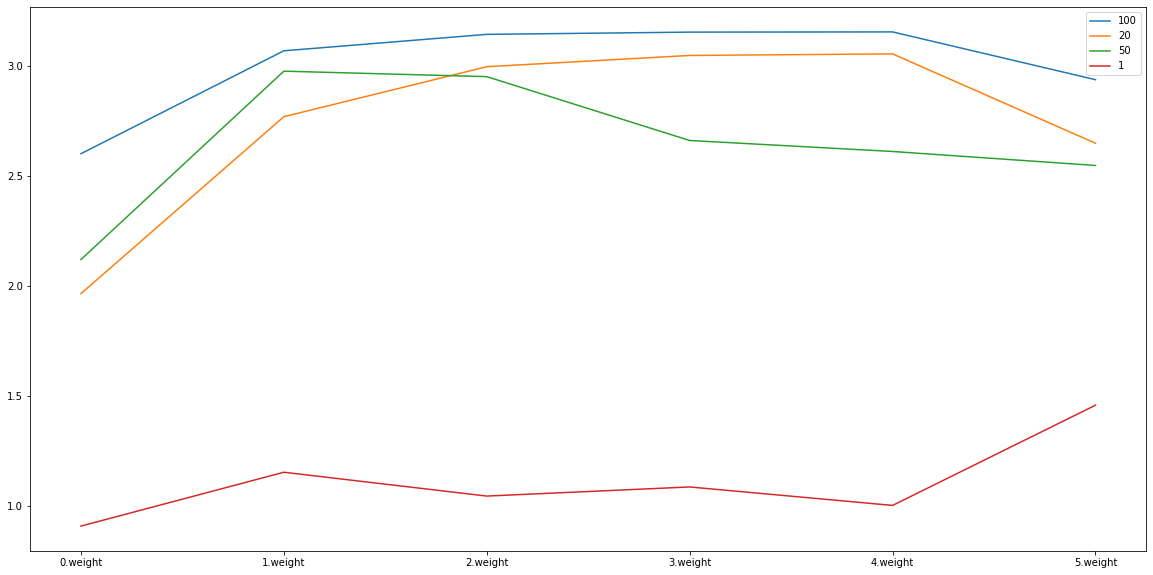

In [314]:
line, = plt.plot(layrnames, width100)
line.set_label('100')
line, = plt.plot(layrnames, width20)
line.set_label('20')
line, = plt.plot(layrnames, width5)
line.set_label('50')
line, = plt.plot(layrnames, width1)
line.set_label('1')
plt.legend()

## depth: 10 hl

### width: 1

In [274]:
#iris_state_1_deep = net.state_dict()

In [304]:
net = NN_deep(sz=1)
net.load_state_dict(iris_state_1_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width1deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width1deep.append(torch.mean(param).item())

parameter size:  torch.Size([1, 4])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([3, 1])
parameter size:  torch.Size([3])
tensor(0.9076)
tensor(1.5106)
tensor(1.7793)
tensor(1.7184)
tensor(1.7457)
tensor(1.7103)
tensor(1.5623)
tensor(1.4274)
tensor(1.4514)
tensor(2.1918)


### width: 5

In [280]:
#iris_state_5_deep = net.state_dict()

In [302]:
net = NN_deep(sz=5)
net.load_state_dict(iris_state_5_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width5deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width5deep.append(torch.mean(param).item())

parameter size:  torch.Size([5, 4])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([3, 5])
parameter size:  torch.Size([3])
tensor(1.5332)
tensor(2.9175)
tensor(2.9609)
tensor(2.9698)
tensor(2.9768)
tensor(2.9628)
tensor(2.9678)
tensor(2.9120)
tensor(2.7839)
tensor(2.6071)


### width: 20

In [285]:
#iris_state_20_deep = net.state_dict()

In [301]:
net = NN_deep(sz=20)
net.load_state_dict(iris_state_20_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width20deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width20deep.append(torch.mean(param).item())

parameter size:  torch.Size([20, 4])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([3, 20])
parameter size:  torch.Size([3])
tensor(2.5927)
tensor(3.1553)
tensor(3.1542)
tensor(3.1531)
tensor(3.1524)
tensor(3.1506)
tensor(3.1479)
tensor(3.1457)
tensor(3.1442)
tensor(2.9942)


### width: 100

In [293]:
#iris_state_100_deep = net.state_dict()

In [300]:
net = NN_deep(sz=100)
net.load_state_dict(iris_state_100_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width100deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width100deep.append(torch.mean(param).item())

parameter size:  torch.Size([100, 4])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([100, 100])
parameter size:  torch.Size([100])
parameter size:  torch.Size([3, 100])
parameter size:  torch.Size([3])
tensor(2.7640)
tensor(3.0975)
tensor(3.1536)
tensor(3.1581)
tensor(3.1590)
tensor(3.1591)
tensor(3.1587)
tensor(3.1583)
tensor(3.1581)
tensor(3.0054)


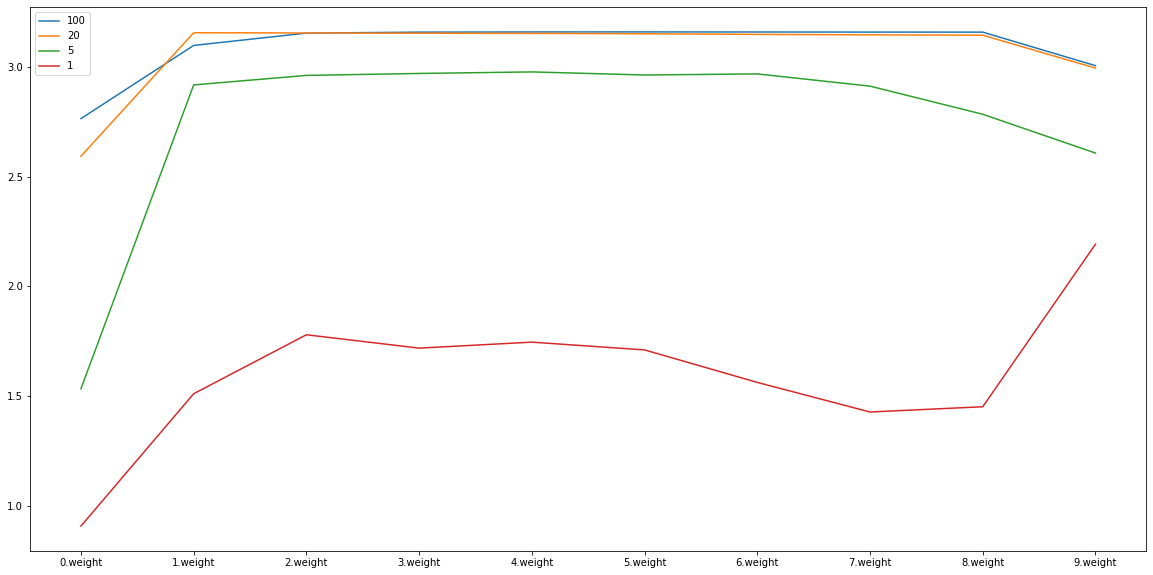

In [315]:
line, = plt.plot(deepnames, width100deep)
line.set_label('100')
line, = plt.plot(deepnames, width20deep)
line.set_label('20')
line, = plt.plot(deepnames, width5deep)
line.set_label('5')
line, = plt.plot(deepnames, width1deep)
line.set_label('1')
plt.legend()

In [296]:
deepnames = []
for key in iris_state_100_deep.keys():
    if 'weight' in key:
        deepnames.append(key)
layrnames = []
for key in iris_state_100.keys():
    if 'weight' in key:
        layrnames.append(key)